In [1]:
##### MODELING LIBRARIES #####
from sklearn.linear_model import LassoCV

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from patsy import dmatrices, dmatrix

from sklearn.metrics import mean_squared_error, r2_score

##### FORMATTING AND GRAPHING LIBRARIES #####
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

##### TIMING AND UTILITY LIBRARIES #####
from datetime import datetime
import timeit
from dateutil.relativedelta import relativedelta 
import random

In [10]:
##### IMPORT PREPARED DATA #####
print('Reading pre-built dataset...')
df_full = pd.read_csv('../PJM_Weekly_Model/sample_base_data.csv', index_col = 0, parse_dates = [0])

# Drop initial null rows from missing lagged values
df_full = df_full.iloc[169:,:]

# Infill remaining nulls (from missing daylight savings hour) with previous value
backfilled = df_full.isna().sum().sum()
print('Backfilling %s null values...'%(backfilled))
df_full = df_full.fillna(method = 'backfill')

# Convert date, time, holiday columns to categorical variables
for col in ['Month','WeekDay','Day','Hour']:
    df_full[col] = df_full[col].astype('category')
    
# Create dataframe for actual loads and predicted train and test values
df_train = pd.DataFrame(df_full['value'])
df_test = pd.DataFrame(df_full['value'])

Reading pre-built dataset...
Backfilling 4 null values...


In [11]:
# MAPE function taken from:
# https://www.statology.org/mape-python/
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

In [12]:
##### LASSO REGRESSION ON MOVING TRAINING WINDOW #####
tic = timeit.default_timer()
print("\nDefining training set and creating regression model fit...")

# Define shift variable for taking moving sample of data
data_shift = 0

while data_shift + 18240 < df_full.shape[0]:
    # Limit dataset to roughly 13 months of data (18240 hours)
    df_modeling = df_full.iloc[data_shift:18240 + data_shift,:].copy()

    # Set random seed
    random.seed(238)

    # Use Patsy to create the one-hot encoded dummy variables with interactions 
    y, X =  dmatrices('value~LoadLag+LoadLagSq+LoadLag3+Light+WWP+THI+WWPSq+THISq+WWPLag+THILag+WWPLagSq+THILagSq+Month+Day+WeekDay+Hour+Holiday+WWP*Hour+WWP*Day+WWP*Holiday+WWP*Month+WWP*WeekDay+WWPSq*Hour+WWPSq*Day+WWPSq*Holiday+WWPSq*Month+WWPSq*WeekDay+THI*Hour+THI*Day+THI*Holiday+THI*Month+THI*WeekDay+THISq*Hour+THISq*Day+THISq*Holiday+THISq*Month+THISq*WeekDay+Month:Day+Hour:Day+Month:Holiday+Month:WeekDay+Hour:WeekDay+WeekDay:Holiday+THI:WWP',df_modeling,return_type='dataframe')

    # Split data into training and testing data sets with two-year training sample (8760 h/yr * 2)
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 17520 / X.shape[0], shuffle = False)

    # Standardize both datasets
    ss = StandardScaler()

    X_train_ss = ss.fit_transform(X_train)
    X_test_ss = ss.transform(X_test)

    # Create the cross validation object with ten folds
    lasso_cv = LassoCV(cv=10, tol = 0.01, n_jobs = -1)

    # Fit the model to the standardized data
    lasso_fit = lasso_cv.fit(X_train_ss,y_train['value'])
    
    # Define name for current model as first date of the testing dataset
    model_date = datetime.date(X_test.index[0])
    
    # Add predictions to target dataframes
    y_train[model_date] = lasso_fit.predict(X_train_ss)
    y_test[model_date] = lasso_fit.predict(X_test_ss)
    
    # Output model results
    print('\n%s Model Results' % (model_date))
    
    # Calculate r2 scores for training and testing data
    train_r2 = round(lasso_fit.score(X_train_ss,y_train['value']),3)
    test_r2 = round(lasso_fit.score(X_test_ss,y_test['value']),3)
    print('Training data r2: %s' % (train_r2))
    print('Testing data r2: %s' % (test_r2))

    # Calculate MAPE scores for training and testing data
    train_mape = round(mape(y_train['value'], y_train[model_date]),3)
    test_mape = round(mape(y_test['value'], y_test[model_date]),3)
    print('Training data MAPE: %s' % (train_mape))
    print('Testing data MAPE: %s' % (test_mape))

    # Add the model predictions to the respective dataframes
    df_train = pd.merge(df_train, y_train.drop(columns = 'value'), how = 'left', left_index = True, right_index = True)
    df_test = pd.merge(df_test, y_test.drop(columns = 'value'), how = 'left', left_index = True, right_index = True)
    
    # Increment the data shift by one week (168 hours)
    data_shift += 168

toc = timeit.default_timer()
print('\nAll LASSO regression fits created in %0.2f seconds' % (toc-tic))


Defining training set and creating regression model fit...


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2019-01-07 Model Results
Training data r2: 0.968
Testing data r2: 0.869
Training data MAPE: 2.467
Testing data MAPE: 3.146


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2019-01-14 Model Results
Training data r2: 0.968
Testing data r2: 0.881
Training data MAPE: 2.476
Testing data MAPE: 2.98


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2019-01-21 Model Results
Training data r2: 0.968
Testing data r2: 0.893
Training data MAPE: 2.475
Testing data MAPE: 2.827


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2019-01-28 Model Results
Training data r2: 0.968
Testing data r2: 0.864
Training data MAPE: 2.468
Testing data MAPE: 3.328


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2019-02-04 Model Results
Training data r2: 0.968
Testing data r2: 0.784
Training data MAPE: 2.493
Testing data MAPE: 3.213


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2019-02-11 Model Results
Training data r2: 0.968
Testing data r2: 0.796
Training data MAPE: 2.49
Testing data MAPE: 3.429


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2019-02-18 Model Results
Training data r2: 0.967
Testing data r2: 0.856
Training data MAPE: 2.499
Testing data MAPE: 3.315


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2019-02-25 Model Results
Training data r2: 0.967
Testing data r2: 0.902
Training data MAPE: 2.496
Testing data MAPE: 2.861


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2019-03-04 Model Results
Training data r2: 0.967
Testing data r2: 0.917
Training data MAPE: 2.497
Testing data MAPE: 2.877


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2019-03-11 Model Results
Training data r2: 0.967
Testing data r2: 0.874
Training data MAPE: 2.503
Testing data MAPE: 3.025


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2019-03-18 Model Results
Training data r2: 0.967
Testing data r2: 0.881
Training data MAPE: 2.507
Testing data MAPE: 3.155


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2019-03-25 Model Results
Training data r2: 0.967
Testing data r2: 0.868
Training data MAPE: 2.511
Testing data MAPE: 3.339


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2019-04-01 Model Results
Training data r2: 0.967
Testing data r2: 0.863
Training data MAPE: 2.512
Testing data MAPE: 3.348


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2019-04-08 Model Results
Training data r2: 0.967
Testing data r2: 0.873
Training data MAPE: 2.517
Testing data MAPE: 3.124


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2019-04-15 Model Results
Training data r2: 0.967
Testing data r2: 0.904
Training data MAPE: 2.507
Testing data MAPE: 2.755


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2019-04-22 Model Results
Training data r2: 0.967
Testing data r2: 0.913
Training data MAPE: 2.507
Testing data MAPE: 2.728


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2019-04-29 Model Results
Training data r2: 0.967
Testing data r2: 0.927
Training data MAPE: 2.506
Testing data MAPE: 2.769


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2019-05-06 Model Results
Training data r2: 0.968
Testing data r2: 0.932
Training data MAPE: 2.484
Testing data MAPE: 2.873


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2019-05-13 Model Results
Training data r2: 0.968
Testing data r2: 0.935
Training data MAPE: 2.472
Testing data MAPE: 2.922


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2019-05-20 Model Results
Training data r2: 0.968
Testing data r2: 0.924
Training data MAPE: 2.463
Testing data MAPE: 3.278


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2019-05-27 Model Results
Training data r2: 0.968
Testing data r2: 0.933
Training data MAPE: 2.455
Testing data MAPE: 3.421


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2019-06-03 Model Results
Training data r2: 0.968
Testing data r2: 0.951
Training data MAPE: 2.434
Testing data MAPE: 3.494


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2019-06-10 Model Results
Training data r2: 0.969
Testing data r2: 0.959
Training data MAPE: 2.431
Testing data MAPE: 3.303


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2019-06-17 Model Results
Training data r2: 0.968
Testing data r2: 0.97
Training data MAPE: 2.424
Testing data MAPE: 2.719


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2019-06-24 Model Results
Training data r2: 0.968
Testing data r2: 0.961
Training data MAPE: 2.424
Testing data MAPE: 2.925


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2019-07-01 Model Results
Training data r2: 0.969
Testing data r2: 0.961
Training data MAPE: 2.422
Testing data MAPE: 2.967


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2019-07-08 Model Results
Training data r2: 0.969
Testing data r2: 0.965
Training data MAPE: 2.423
Testing data MAPE: 2.744


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2019-07-15 Model Results
Training data r2: 0.969
Testing data r2: 0.96
Training data MAPE: 2.428
Testing data MAPE: 3.019


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2019-07-22 Model Results
Training data r2: 0.969
Testing data r2: 0.964
Training data MAPE: 2.424
Testing data MAPE: 2.704


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2019-07-29 Model Results
Training data r2: 0.969
Testing data r2: 0.961
Training data MAPE: 2.432
Testing data MAPE: 3.01


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2019-08-05 Model Results
Training data r2: 0.969
Testing data r2: 0.96
Training data MAPE: 2.43
Testing data MAPE: 3.176


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2019-08-12 Model Results
Training data r2: 0.97
Testing data r2: 0.953
Training data MAPE: 2.43
Testing data MAPE: 3.433


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2019-08-19 Model Results
Training data r2: 0.97
Testing data r2: 0.943
Training data MAPE: 2.433
Testing data MAPE: 3.768


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2019-08-26 Model Results
Training data r2: 0.97
Testing data r2: 0.914
Training data MAPE: 2.432
Testing data MAPE: 4.134


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2019-09-02 Model Results
Training data r2: 0.97
Testing data r2: 0.915
Training data MAPE: 2.439
Testing data MAPE: 3.91


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2019-09-09 Model Results
Training data r2: 0.97
Testing data r2: 0.885
Training data MAPE: 2.436
Testing data MAPE: 4.94


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2019-09-16 Model Results
Training data r2: 0.97
Testing data r2: 0.816
Training data MAPE: 2.422
Testing data MAPE: 5.959


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2019-09-23 Model Results
Training data r2: 0.97
Testing data r2: 0.819
Training data MAPE: 2.43
Testing data MAPE: 5.296


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2019-09-30 Model Results
Training data r2: 0.97
Testing data r2: 0.771
Training data MAPE: 2.425
Testing data MAPE: 5.403


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2019-10-07 Model Results
Training data r2: 0.97
Testing data r2: 0.648
Training data MAPE: 2.43
Testing data MAPE: 4.619


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2019-10-14 Model Results
Training data r2: 0.969
Testing data r2: 0.836
Training data MAPE: 2.463
Testing data MAPE: 3.517


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2019-10-21 Model Results
Training data r2: 0.969
Testing data r2: 0.915
Training data MAPE: 2.466
Testing data MAPE: 2.872


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2019-10-28 Model Results
Training data r2: 0.969
Testing data r2: 0.909
Training data MAPE: 2.473
Testing data MAPE: 2.544


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2019-11-04 Model Results
Training data r2: 0.969
Testing data r2: 0.873
Training data MAPE: 2.487
Testing data MAPE: 2.751


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2019-11-11 Model Results
Training data r2: 0.969
Testing data r2: 0.874
Training data MAPE: 2.479
Testing data MAPE: 2.734


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2019-11-18 Model Results
Training data r2: 0.969
Testing data r2: 0.88
Training data MAPE: 2.48
Testing data MAPE: 2.808

2019-11-25 Model Results
Training data r2: 0.969
Testing data r2: 0.862
Training data MAPE: 2.467
Testing data MAPE: 3.251

All LASSO regression fits created in 1878.97 seconds


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [15]:
# Write prediction dataframes to CSV
df_train.to_csv('../Outputs/LASSO_validation_train_preds.csv')
df_test.to_csv('../Outputs/LASSO_validation_test_preds.csv')

In [18]:
# Write model scores to data frame - Meant to include this in loop initially
# Create dataframe for scores
df_scores = pd.DataFrame(index = df_train.drop(columns = 'value').columns)

# Create empty columns for scores
df_scores['train_r2'], df_scores['test_r2'], df_scores['train_mape'], df_scores['test_mape'] = [np.nan,np.nan,np.nan,np.nan]

# Loop through each forecast
for column in df_train.columns[1:]:
    # Slice training and testing dataframes to desired forecast
    df_train_calc = df_train[['value',column]].dropna()
    df_test_calc = df_test[['value',column]].dropna()
    
    # Calciulate r2 scores for training and testing data
    train_r2 = round(r2_score(df_train_calc['value'],df_train_calc[column]),3)
    test_r2 = round(r2_score(df_test_calc['value'],df_test_calc[column]),3)

    # Calculate MAPE scores for training and testing data
    train_mape = round(mape(df_train_calc['value'],df_train_calc[column]),2)
    test_mape = round(mape(df_test_calc['value'],df_test_calc[column]),2)
    
    # Assign scores
    df_scores.loc[df_scores.index == column,:] = [train_r2, test_r2, train_mape, test_mape]

In [37]:
# Write scores dataframes to CSV
df_scores.to_csv('../Outputs/LASSO_validation_scores.csv')

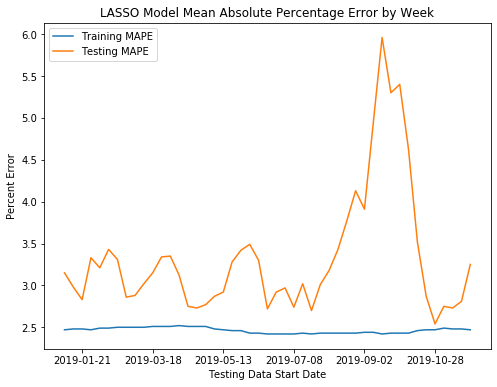

In [61]:
plt.figure(figsize = (8,6))
plt.plot(df_scores[['train_mape','test_mape']])
plt.xticks(df_scores.index[2::8])
plt.xlabel('Testing Data Start Date')
plt.ylabel('Percent Error')
plt.title('LASSO Model Mean Absolute Percentage Error by Week')
plt.legend(labels = ['Training MAPE','Testing MAPE']);